In [91]:
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import re

from mmsdk import mmdatasdk
from mmsdk.mmdatasdk.computational_sequence.computational_sequence import computational_sequence
from mmsdk.mmdatasdk.dataset.standard_datasets.CMU_MOSEI import cmu_mosei_std_folds

import torch
import torch.nn as nn

from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm_notebook
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

In [92]:
#@title: Settings
# Set to True to use the corresponding model
model_switch = {
    "use_cnn": True,
    "use_dnn": True,
    "use_lr": True,
    "use_xgboost": True,
    "use_rf": True,
    "use_stack": False,
}
compare_models = True  # Set to True to compare the models
see_dataloader = False  # Set to True to see the dataloader output

In [93]:
with open('data/aligned_mosei.pkl', 'rb') as f:
    dataset = pickle.load(f)

print(type(dataset))
print(dataset.keys() if hasattr(dataset, 'keys') else dataset)

<class 'mmsdk.mmdatasdk.dataset.dataset.mmdataset'>
dict_keys(['CMU_MOSEI_TimestampedWordVectors', 'CMU_MOSEI_VisualFacet42', 'CMU_MOSEI_COVAREP', 'CMU_MOSEI_Labels'])


In [94]:
visual_field = 'CMU_MOSEI_VisualFacet42'
acoustic_field = 'CMU_MOSEI_COVAREP'
text_field = 'CMU_MOSEI_TimestampedWordVectors'
label_field = 'CMU_MOSEI_Labels'

features = [
    text_field, 
    visual_field, 
    acoustic_field
]

len(dataset[text_field].keys())

23248

In [95]:
dataset[label_field].keys()

dict_keys(['--qXJuDtHPw[0]', '-3g5yACwYnA[0]', '-3g5yACwYnA[1]', '-3g5yACwYnA[2]', '-3g5yACwYnA[3]', '-3g5yACwYnA[4]', '-3g5yACwYnA[5]', '-3nNcZdcdvU[0]', '-3nNcZdcdvU[1]', '-3nNcZdcdvU[2]', '-571d8cVauQ[0]', '-571d8cVauQ[1]', '-571d8cVauQ[2]', '-6rXp3zJ3kc[0]', '-6rXp3zJ3kc[1]', '-6rXp3zJ3kc[2]', '-9YyBTjo1zo[0]', '-9YyBTjo1zo[1]', '-9YyBTjo1zo[2]', '-9YyBTjo1zo[3]', '-9YyBTjo1zo[4]', '-9y-fZ3swSY[0]', '-9y-fZ3swSY[1]', '-9y-fZ3swSY[2]', '-9y-fZ3swSY[3]', '-9y-fZ3swSY[4]', '-9y-fZ3swSY[5]', '-9y-fZ3swSY[6]', '-9y-fZ3swSY[7]', '-AUZQgSxyPQ[0]', '-Alixo7euuU[0]', '-Alixo7euuU[1]', '-Alixo7euuU[2]', '-Alixo7euuU[3]', '-Alixo7euuU[4]', '-Alixo7euuU[5]', '-Alixo7euuU[6]', '-Alixo7euuU[7]', '-Alixo7euuU[8]', '-Alixo7euuU[9]', '-Alixo7euuU[10]', '-Alixo7euuU[11]', '-Alixo7euuU[12]', '-Alixo7euuU[13]', '-Eqdz5y4pEY[0]', '-HeZS2-Prhc[0]', '-HeZS2-Prhc[1]', '-HeZS2-Prhc[2]', '-HeZS2-Prhc[3]', '-HvKLjmsO5U[0]', '-HvKLjmsO5U[1]', '-HwX2H8Z4hY[0]', '-HwX2H8Z4hY[1]', '-HwX2H8Z4hY[2]', '-HwX2H8Z4hY[

In [96]:
dataset[label_field]['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.       , 0.6666667, 0.       , 0.       , 0.       , 0.       ,
         0.       ]], dtype=float32)}

In [97]:
# 先用 dict 保存新数据
sentiment_lables = {}
emotion_lables = {}

for key in dataset[label_field].keys():
    features = dataset[label_field][key]['features']
    sentiment_lables[key] = dataset[label_field][key].copy()
    emotion_lables[key] = dataset[label_field][key].copy()
    sentiment_lables[key]['features'] = features[0][0]
    sentiment_lables[key]['features'] = np.expand_dims(np.expand_dims(sentiment_lables[key]['features'], axis=0), axis=0)
    emotion_lables[key]['features'] = features[0][1:]
    emotion_lables[key]['features'] = np.expand_dims(emotion_lables[key]['features'], axis=0)

print(sentiment_lables.keys())
print(emotion_lables.keys())

dict_keys(['--qXJuDtHPw[0]', '-3g5yACwYnA[0]', '-3g5yACwYnA[1]', '-3g5yACwYnA[2]', '-3g5yACwYnA[3]', '-3g5yACwYnA[4]', '-3g5yACwYnA[5]', '-3nNcZdcdvU[0]', '-3nNcZdcdvU[1]', '-3nNcZdcdvU[2]', '-571d8cVauQ[0]', '-571d8cVauQ[1]', '-571d8cVauQ[2]', '-6rXp3zJ3kc[0]', '-6rXp3zJ3kc[1]', '-6rXp3zJ3kc[2]', '-9YyBTjo1zo[0]', '-9YyBTjo1zo[1]', '-9YyBTjo1zo[2]', '-9YyBTjo1zo[3]', '-9YyBTjo1zo[4]', '-9y-fZ3swSY[0]', '-9y-fZ3swSY[1]', '-9y-fZ3swSY[2]', '-9y-fZ3swSY[3]', '-9y-fZ3swSY[4]', '-9y-fZ3swSY[5]', '-9y-fZ3swSY[6]', '-9y-fZ3swSY[7]', '-AUZQgSxyPQ[0]', '-Alixo7euuU[0]', '-Alixo7euuU[1]', '-Alixo7euuU[2]', '-Alixo7euuU[3]', '-Alixo7euuU[4]', '-Alixo7euuU[5]', '-Alixo7euuU[6]', '-Alixo7euuU[7]', '-Alixo7euuU[8]', '-Alixo7euuU[9]', '-Alixo7euuU[10]', '-Alixo7euuU[11]', '-Alixo7euuU[12]', '-Alixo7euuU[13]', '-Eqdz5y4pEY[0]', '-HeZS2-Prhc[0]', '-HeZS2-Prhc[1]', '-HeZS2-Prhc[2]', '-HeZS2-Prhc[3]', '-HvKLjmsO5U[0]', '-HvKLjmsO5U[1]', '-HwX2H8Z4hY[0]', '-HwX2H8Z4hY[1]', '-HwX2H8Z4hY[2]', '-HwX2H8Z4hY[

In [98]:
sentiment_lables['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[1.]], dtype=float32)}

In [99]:
emotion_lables['--qXJuDtHPw[0]']

{'intervals': array([[23.199, 30.325]]),
 'features': array([[0.6666667, 0.       , 0.       , 0.       , 0.       , 0.       ]],
       dtype=float32)}

In [100]:
# Split the dataset.
# obtain the train/valid/test splits - these splits are based on video IDs
train_split = cmu_mosei_std_folds.standard_train_fold
valid_split = cmu_mosei_std_folds.standard_valid_fold
test_split = cmu_mosei_std_folds.standard_test_fold

# inspect the splits: they only contain video IDs
print(test_split)

['7l3BNtSE0xc', 'dZFV0lyedX4', '286943', '126872', 'qgC8_emxSIU', 'kld9r0iFkWM', 'rC29Qub0U7A', '4YfyP0uIqw0', 'FMenDv3y8jc', '4wLP4elp1uM', 'KYQTwFVBzME', '27v7Blr0vjw', 'DnBHq5I52LM', 'HR18U0yAlTc', 'x266rUJQC_8', 'd1CDP6sMuLA', 'xSCvspXYU9k', '4EDblUpJieU', '4o4ilPK9rl8', '53609', 'SZ7HK5ns6mE', '243981', 'ySblgk7T7eQ', 'MYEyQUpMe3k', 'EujJ0SwiCRE', '3HyAaqre_Fk', 'iQDB_OkAQWs', 'gE7kUqMqQ9g', 'eFV7iFPYZB4', 'IRSxo_XXArg', '3hOlJf_JQDs', 'BRSyH6yfDLk', '1jogeKX0wGw', '3At-BKm9eYk', 'NVLPURuAVLU', 'pZye4zFzk3o', 'l1jW3OMXUzs', 'XKyumlBmix8', 'eKQKEi2-0Ws', 'WgI8IbJtXHw', 'tnWmVXZ87h0', 'YCEllKyaCrc', 'W1CWpktWtTs', '8wQhzezNcUY', '0bxhZ-LIfZY', 'lrjm6F3JJgg', 'Vdf1McvE9ao', 'eQc5uI7FKCU', '2QXHdu2zlQY', 'YCI-ZzclIPQ', '2Ky9DBSl49w', 'SKTyBOhDX6U', 'b86B3hP8ARM', '23656', 'kpS4BXif_Sw', 'dR68gbeOWOc', 'tC2KicUHB9Q', 'absh1hsZeF0', 'c5zxqITn3ZM', 'uogwnZGb-iE', '46495', 'Sq6DIhFxPqQ', 'PexNiFbPTYM', 'z441aDJvAcU', 'OORklkFql3k', 'WbtsuXkaGeg', 'grsV1YN1z5s', 'Gc_zIjqqUys', '424SXFTCFsA

In [101]:
# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 0

# place holders for the final train/valid/test dataset
train = []
valid = []
test = []

# define a regular expression to extract the video ID out of the keys
pattern = re.compile('(.*)\[.*\]')
num_drop = 0 # a counter to count how many data points went into some processing issues

valid_keys = set(dataset[label_field].keys()) & set(dataset[text_field].keys()) & set(dataset[visual_field].keys()) & set(dataset[acoustic_field].keys())


In [102]:
# iterate over the segments in the dataset
for segment in dataset[label_field].keys():
    
    if segment not in valid_keys:
        continue

    # get the video ID and the features out of the aligned dataset
    vid = re.search(pattern, segment).group(1)
    label = sentiment_lables[segment]['features']
    words = dataset[text_field][segment]['features']
    visual = dataset[visual_field][segment]['features']
    acoustic = dataset[acoustic_field][segment]['features']

    # if the sequences are not same length after alignment, there must be some problem with some modalities
    # we should drop it or inspect the data again
    if not words.shape[0] == visual.shape[0] == acoustic.shape[0]:
        print(f"Encountered datapoint {vid} with text shape {words.shape}, visual shape {visual.shape}, acoustic shape {acoustic.shape}")
        num_drop += 1

    # remove nan values
    label = np.nan_to_num(label)
    words = np.nan_to_num(words)
    visual = np.nan_to_num(visual)
    acoustic = np.nan_to_num(acoustic)

    # z-normalization per instance and remove nan/infs
    visual = np.nan_to_num((visual - visual.mean(0, keepdims=True)) / (EPS + np.std(visual, axis=0, keepdims=True)))
    acoustic = np.nan_to_num((acoustic - acoustic.mean(0, keepdims=True)) / (EPS + np.std(acoustic, axis=0, keepdims=True)))

    if vid in train_split:
        train.append(((words, visual, acoustic), label, segment))
    elif vid in valid_split:
        valid.append(((words, visual, acoustic), label, segment))
    elif vid in test_split:
        test.append(((words, visual, acoustic), label, segment))
    else:
        print(f"Found video that doesn't belong to any splits: {vid}")

print(f"Total number of {num_drop} datapoints have been dropped.")

Found video that doesn't belong to any splits: -9YyBTjo1zo
Found video that doesn't belong to any splits: -9YyBTjo1zo
Found video that doesn't belong to any splits: -9YyBTjo1zo
Found video that doesn't belong to any splits: -9YyBTjo1zo
Found video that doesn't belong to any splits: -9YyBTjo1zo
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7euuU
Found video that doesn't belong to any splits: -Alixo7eu

In [103]:
# let's see the size of each set and shape of data
print(len(train))
print(len(valid))
print(len(test))

print(train[0][0][0].shape)
print(train[0][0][1].shape)
print(train[0][0][2].shape)
print(train[0][1].shape)

print(train[0][0])
print(train[0][1])
print(train[0][2])

16322
1871
4659
(55, 300)
(55, 35)
(55, 74)
(1, 1)
(array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.33578  ,  0.30902  ,  0.12098  , ...,  0.26556  , -0.15987  ,
        -0.033962 ],
       [-0.084961 ,  0.502    ,  0.0023823, ..., -0.21511  , -0.26304  ,
        -0.0060173],
       ...,
       [-0.028387 ,  0.050244 , -0.076597 , ..., -0.16328  , -0.043587 ,
         0.036996 ],
       [-0.70567  ,  0.48464  , -0.26169  , ..., -0.1398   ,  0.42836  ,
         0.017546 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]]), array([[-5.0590074e-01, -5.4795736e-01,  4.1057914e-01, ...,
        -3.3446416e-01, -8.5609153e-02,  4.7459543e-01],
       [ 9.0985417e-02, -1.4090555e+00,  3.1989036e+00, ...,
        -6.6909468e-01, -2.3426114e-01, -2.6542366e-01],
       [-6.6859627e-01,  3.3285603e-01,  1.8611795e-01, ...,
         2.0832238e-01,  1.0378593e+00, -9.4906610e-01],
       ...,
    

In [ ]:
def multi_collate(batch, convert=True):
    '''
    Collate functions assume batch = [Dataset[i] for i in index_set]
    '''
    batch = sorted(batch, key=lambda x: x[0][0].shape[0], reverse=True)
    labels = torch.cat([torch.from_numpy(sample[1]) for sample in batch], dim=0)
    sentences = pad_sequence([torch.FloatTensor(sample[0][0]) for sample in batch])  # [seq_len, batch, feat]
    visual = pad_sequence([torch.FloatTensor(sample[0][1]) for sample in batch])
    acoustic = pad_sequence([torch.FloatTensor(sample[0][2]) for sample in batch])
    
    # if we use CNN, we need to transpose the data to [batch, feat, seq_len]
    if convert:
        sentences = sentences.transpose(0, 1)
        visual = visual.transpose(0, 1)
        acoustic = acoustic.transpose(0, 1)

    lengths = torch.LongTensor([sample[0][0].shape[0] for sample in batch])
    return sentences, visual, acoustic, labels, lengths

def multi_collate_dnn(batch):
    return multi_collate(batch, convert=False)

def get_dataloaders(train, valid, test, batch_sz=32, collate_fn=multi_collate):
    """
    Construct dataloaders for train, valid, and test sets.
    valid and test use ~3x batch size since no_grad is used during eval.
    """
    train_loader = DataLoader(train, shuffle=True, batch_size=batch_sz, collate_fn=collate_fn)
    valid_loader = DataLoader(valid, shuffle=False, batch_size=batch_sz*3, collate_fn=collate_fn)
    test_loader = DataLoader(test, shuffle=False, batch_size=batch_sz*3, collate_fn=collate_fn)
    return train_loader, valid_loader, test_loader


if see_dataloader:
    print("See dataloader output:")
    # create a temporary dataloader just to see how the batch looks like
    temp_loader = iter(DataLoader(test, shuffle=True, batch_size=8, collate_fn=multi_collate))
    batch = next(temp_loader)

    print(batch[0].shape) # word vectors
    print(batch[1].shape) # visual features
    print(batch[2].shape) # acoustic features
    print(batch[3]) # labels
    print(batch[4]) # lengths
    print(batch[4].size(0)) # batch size



In [105]:
def train_nn_model(
    model_class,
    train_loader,
    valid_loader,
    input_sizes,
    hidden_sizes,
    dropouts,
    post_fusion_dim,
    output_size,
    fusion_type,
    max_epoch=3,
    grad_clip_value=1.0,
    weight_decay=0.1,
    patience=8,
    num_trials=3,
    save_dir='./ckpt'
):
    import os
    import time
    import torch
    import torch.nn as nn
    from tqdm import tqdm_notebook
    from torch.optim import Adam

    torch.manual_seed(123)
    torch.cuda.manual_seed_all(123)
    CUDA = torch.cuda.is_available()

    date = time.strftime('%m%d%H%M%S', time.localtime())
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    model_save_path = os.path.join(save_dir, '{}_model.std'.format(date))
    optim_save_path = os.path.join(save_dir, '{}_optim.std'.format(date))

    print(f"model_class: {model_class}, input_sizes: {input_sizes}, hidden_sizes: {hidden_sizes}, dropouts: {dropouts}, post_fusion_dim: {post_fusion_dim}, output_size: {output_size}, fusion_type: {fusion_type}")
    model = model_class(input_sizes, hidden_sizes, dropouts, post_fusion_dim, output_size, fusion_type=fusion_type)
    print(f"define optimizer with weight decay: {weight_decay}, grad clip value: {grad_clip_value}")
    optimizer = Adam([param for param in model.parameters() if param.requires_grad], weight_decay=weight_decay)

    if CUDA:
        model.cuda()
    criterion = nn.L1Loss(reduction='sum')
    best_valid_loss = float('inf')
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
    lr_scheduler.step()
    train_losses = []
    valid_losses = []
    curr_patience = patience
    trials_left = num_trials

    for e in range(max_epoch):
        model.train()
        train_iter = tqdm_notebook(train_loader)
        train_loss = 0.0
        for batch in train_iter:
            model.zero_grad()
            t, v, a, y, l = batch
            batch_size = t.size(0)
            if CUDA:
                t = t.cuda()
                v = v.cuda()
                a = a.cuda()
                y = y.cuda()
                l = l.cuda()
            y_tilde = model(a, v, t, l)
            loss = criterion(y_tilde, y)
            loss.backward()
            torch.nn.utils.clip_grad_value_([param for param in model.parameters() if param.requires_grad], grad_clip_value)
            optimizer.step()
            train_iter.set_description(f"Epoch {e}/{max_epoch}, current batch loss: {round(loss.item()/batch_size, 4)}")
            train_loss += loss.item()
        train_loss = train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f"Training loss: {round(train_loss, 4)}")

        model.eval()
        with torch.no_grad():
            valid_loss = 0.0
            for batch in valid_loader:
                model.zero_grad()
                t, v, a, y, l = batch
                if CUDA:
                    t = t.cuda()
                    v = v.cuda()
                    a = a.cuda()
                    y = y.cuda()
                    l = l.cuda()
                y_tilde = model(a, v, t, l)
                loss = criterion(y_tilde, y)
                valid_loss += loss.item()
        valid_loss = valid_loss / len(valid_loader.dataset)
        valid_losses.append(valid_loss)
        print(f"Validation loss: {round(valid_loss, 4)}")
        print(f"Current patience: {curr_patience}, current trial: {trials_left}.")
        if valid_loss <= best_valid_loss:
            best_valid_loss = valid_loss
            print("Found new best model on valid set!")
            torch.save(model.state_dict(), model_save_path)
            torch.save(optimizer.state_dict(), optim_save_path)
            curr_patience = patience
        else:
            curr_patience -= 1
            if curr_patience <= -1:
                print("Running out of patience, loading previous best model.")
                trials_left -= 1
                curr_patience = patience
                model.load_state_dict(torch.load(model_save_path))
                optimizer.load_state_dict(torch.load(optim_save_path))
                lr_scheduler.step()
                print(f"Current learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")
        if trials_left <= 0:
            print("Running out of patience, early stopping.")
            break

    return model, train_losses, valid_losses


In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
import numpy as np
import xgboost

# For LR, we typically use scikit-learn's LogisticRegression or LinearRegression
def run_linear_regression(train, valid):
    # Prepare data for LR: flatten and concatenate features for each sample
    def prepare_lr_data(data):
        X = []
        y = []
        for (modalities, label, _) in data:
            words, visual, acoustic = modalities
            # Flatten and concatenate all modalities (mean pooling over time dimension)
            feat = np.concatenate([
                words.mean(axis=0),
                visual.mean(axis=0),
                acoustic.mean(axis=0)
            ])
            X.append(feat)
            y.append(label.flatten()[0])
        return np.array(X), np.array(y)

    X_train, y_train = prepare_lr_data(train)
    X_valid, y_valid = prepare_lr_data(valid)

    model = LinearRegression()
    model.fit(X_train, y_train)
    valid_preds = model.predict(X_valid)
    valid_loss = np.mean(np.abs(valid_preds - y_valid))
    print(f"Validation MAE (LR): {valid_loss:.4f}")
    return model, valid_loss

# For XGBoost, we can use the XGBRegressor from xgboost library
def train_xgboost(train, valid):
    X_train, y_train = [], []
    for (modalities, label, _) in train:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_train.append(feat)
        y_train.append(label.flatten()[0])
    X_valid, y_valid = [], []
    for (modalities, label, _) in valid:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_valid.append(feat)
        y_valid.append(label.flatten()[0])
    model = xgboost.XGBRegressor()
    model.fit(np.array(X_train), np.array(y_train))
    valid_preds = model.predict(np.array(X_valid))
    valid_loss = np.mean(np.abs(valid_preds - np.array(y_valid)))
    print(f"Validation MAE (XGBoost): {valid_loss:.4f}")
    return model, valid_loss

# For Random Forest, we can use the RandomForestRegressor from scikit-learn
def train_rf(train, valid):
    X_train, y_train = [], []
    for (modalities, label, _) in train:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_train.append(feat)
        y_train.append(label.flatten()[0])
    X_valid, y_valid = [], []
    for (modalities, label, _) in valid:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_valid.append(feat)
        y_valid.append(label.flatten()[0])
    model = RandomForestRegressor()
    model.fit(np.array(X_train), np.array(y_train))
    valid_preds = model.predict(np.array(X_valid))
    valid_loss = np.mean(np.abs(valid_preds - np.array(y_valid)))
    print(f"Validation MAE (RandomForest): {valid_loss:.4f}")
    return model, valid_loss

# For Stacking, we can use a simple linear model to combine the features from different modalities
def train_stack(train, valid):
    X_train, y_train = [], []
    for (modalities, label, _) in train:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_train.append(feat)
        y_train.append(label.flatten()[0])
    X_valid, y_valid = [], []
    for (modalities, label, _) in valid:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_valid.append(feat)
        y_valid.append(label.flatten()[0])
    # Example stacking: combine LR, RF, and XGBoost as base learners
    estimators = [
        ('lr', LinearRegression()),
        ('rf', RandomForestRegressor()),
        ('xgb', xgboost.XGBRegressor())
    ]
    model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())
    model.fit(np.array(X_train), np.array(y_train))
    valid_preds = model.predict(np.array(X_valid))
    valid_loss = np.mean(np.abs(valid_preds - np.array(y_valid)))
    print(f"Validation MAE (Stacking): {valid_loss:.4f}")
    return model, valid_loss

In [107]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def to_six_classes(arr):
    """
    Flatten the array to 1D and bin the data into 6 equal-width classes (labels 0-5).
    Returns a pandas Series of class labels.
    """
    arr_flat = arr.flatten()
    bins = np.linspace(arr_flat.min(), arr_flat.max(), 7)  # 6 bins require 7 edges
    labels = range(6)
    arr_six_classes = pd.cut(arr_flat, bins=bins, labels=labels, include_lowest=True)
    return arr_six_classes

def evaluate_nn_model(model, test_loader, criterion_test, model_save_path, CUDA, to_six_classes):
    from sklearn.metrics import accuracy_score, precision_recall_fscore_support

    model.load_state_dict(torch.load(model_save_path))
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for batch in test_loader:
            model.zero_grad()
            t, v, a, y, l = batch
            if CUDA:
                t = t.cuda()
                v = v.cuda()
                a = a.cuda()
                y = y.cuda()
                l = l.cuda()
            y_tilde = model(a, v, t, l)
            loss = criterion_test(y_tilde, y)
            y_true.append(y.detach().cpu().numpy())
            y_pred.append(y_tilde.detach().cpu().numpy())
            test_loss += loss.item()
    print(f"Test set performance: {test_loss/len(test_loader.dataset)}")

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)
    print(f"y_true shape: {y_true.shape}, y_pred shape: {y_pred.shape}")
    print(f"y_true: {y_true[:10]}, \ny_pred: {y_pred[:10]}")

    arr_six_classes = to_six_classes(y_pred)
    print("Six-class labels (6-class labels):")
    print(arr_six_classes)

    y_true_bin = y_true >= 0
    y_pred_bin = y_pred >= 0
    bin_acc = accuracy_score(y_true_bin, y_pred_bin)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, average='binary'
    )
    print(f"Test set accuracy is {bin_acc}, Test set precision is {test_precision}, recall is {test_recall}, f1 is {test_f1}")
    return {
        "test_loss": test_loss/len(test_loader.dataset),
        "y_true": y_true,
        "y_pred": y_pred,
        "six_class_labels": arr_six_classes,
        "bin_acc": bin_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }

def evaluate_lr_rf_xgb_stack(model, test):
    # Prepare test data
    X_test, y_test = [], []
    for (modalities, label, _) in test:
        words, visual, acoustic = modalities
        feat = np.concatenate([
            words.mean(axis=0),
            visual.mean(axis=0),
            acoustic.mean(axis=0)
        ])
        X_test.append(feat)
        y_test.append(label.flatten()[0])
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    preds = model.predict(X_test)
    mae = np.mean(np.abs(preds - y_test))
    print(f"Test MAE: {mae:.4f}")
    # 6-class labels
    arr_six_classes = to_six_classes(preds)
    print("Six-class labels (6-class labels):")
    print(arr_six_classes)
    # Binary accuracy
    y_true_bin = y_test >= 0
    y_pred_bin = preds >= 0
    bin_acc = accuracy_score(y_true_bin, y_pred_bin)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        y_true_bin, y_pred_bin, average='binary'
    )
    print(f"Test set accuracy is {bin_acc}, Test set precision is {test_precision}, recall is {test_recall}, f1 is {test_f1}")
    return {
        "test_mae": mae,
        "y_true": y_test,
        "y_pred": preds,
        "six_class_labels": arr_six_classes,
        "bin_acc": bin_acc,
        "precision": test_precision,
        "recall": test_recall,
        "f1": test_f1
    }

In [108]:
import importlib
import time
from nn_models import cnn, dnn
from torch.optim import Adam
import os
import pandas as pd
import matplotlib.pyplot as plt

def predict(model_switch, train, valid, test):
    # Store evaluation results for each model
    eval_results = {}

    # Re-run and collect results for each enabled model
    for model_name, use_flag in model_switch.items():
        if use_flag:
            print(f"\n=== Training and evaluating model: {model_name} ===")
            if model_name == "use_lr":
                print(f"Model summary: Linear Regression")
                model_tuple = run_linear_regression(train, valid)
                model_obj = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
                result = evaluate_lr_rf_xgb_stack(model_obj, test)
                eval_results["Linear Regression"] = result
            elif model_name == "use_xgboost":
                print(f"Model summary: XGBoost")
                model_tuple = train_xgboost(train, valid)
                model_obj = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
                result = evaluate_lr_rf_xgb_stack(model_obj, test)
                eval_results["XGBoost"] = result
            elif model_name == "use_rf":
                print(f"Model summary: Random Forest")
                model_tuple = train_rf(train, valid)
                model_obj = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
                result = evaluate_lr_rf_xgb_stack(model_obj, test)
                eval_results["Random Forest"] = result
            elif model_name == "use_stack":
                print(f"Model summary: Stacking")
                model_tuple = train_stack(train, valid)
                model_obj = model_tuple[0] if isinstance(model_tuple, tuple) else model_tuple
                result = evaluate_lr_rf_xgb_stack(model_obj, test)
                eval_results["Stacking"] = result
            elif model_name == "use_cnn":
                Fusion = cnn.Fusion
                print(f"Model summary: CNN Fusion ({Fusion})")
                train_loader, valid_loader, test_loader = get_dataloaders(train, valid, test)
                model, _, _ = train_nn_model(
                    Fusion,
                    train_loader,
                    valid_loader,
                    input_sizes=[train[0][0][0].shape[1], train[0][0][1].shape[1], train[0][0][2].shape[1]],
                    hidden_sizes=[64, 64, 64],
                    dropouts=[0.3, 0.3, 0.3],
                    post_fusion_dim=128,
                    output_size=1,
                    fusion_type="concat",
                    max_epoch=5,
                    grad_clip_value=1.0,
                    weight_decay=0.05,
                    patience=8,
                    num_trials=3,
                    save_dir='./ckpt'
                )
                model_save_files = [f for f in os.listdir('./ckpt') if f.endswith('_model.std')]
                if model_save_files:
                    model_save_path = os.path.join('./ckpt', sorted(model_save_files)[-1])
                    result = evaluate_nn_model(
                        model,
                        test_loader,
                        nn.L1Loss(reduction='sum'),
                        model_save_path,
                        torch.cuda.is_available(),
                        to_six_classes
                    )
                    eval_results["CNN"] = result
                else:
                    print("Warning: No model checkpoint found in './ckpt'. Skipping evaluation.")
            elif model_name == "use_dnn":
                Fusion = dnn.Fusion
                print(f"Model summary: DNN Fusion ({Fusion})")
                train_loader, valid_loader, test_loader = get_dataloaders(train, valid, test, collate_fn=multi_collate_dnn)
                model, _, _ = train_nn_model(
                    Fusion,
                    train_loader,
                    valid_loader,
                    input_sizes=[train[0][0][0].shape[1], train[0][0][1].shape[1], train[0][0][2].shape[1]],
                    hidden_sizes=[4, 16, 128],
                    dropouts=[0.3, 0.3, 0.3, 0.3],
                    post_fusion_dim=32,
                    output_size=1,
                    fusion_type="tfn",
                    max_epoch=3,
                    grad_clip_value=1.0,
                    weight_decay=0.1,
                    patience=8,
                    num_trials=3,
                    save_dir='./ckpt'
                )
                model_save_files = [f for f in os.listdir('./ckpt') if f.endswith('_model.std')]
                if model_save_files:
                    model_save_path = os.path.join('./ckpt', sorted(model_save_files)[-1])
                    result = evaluate_nn_model(
                        model,
                        test_loader,
                        nn.L1Loss(reduction='sum'),
                        model_save_path,
                        torch.cuda.is_available(),
                        to_six_classes
                    )
                    eval_results["DNN"] = result
                else:
                    print("Warning: No model checkpoint found in './ckpt'. Skipping evaluation.")
            else:
                raise ValueError(f"Unknown model type: {model_name}")
    
    return eval_results

eval_results = predict(model_switch, train, valid, test)


=== Training and evaluating model: use_cnn ===
Model summary: CNN Fusion (<class 'nn_models.cnn.Fusion'>)
model_class: <class 'nn_models.cnn.Fusion'>, input_sizes: [300, 35, 74], hidden_sizes: [64, 64, 64], dropouts: [0.3, 0.3, 0.3], post_fusion_dim: 128, output_size: 1, fusion_type: concat
define optimizer with weight decay: 0.05, grad clip value: 1.0


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.8352
Validation loss: 0.6811
Current patience: 8, current trial: 3.
Found new best model on valid set!


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.7528
Validation loss: 0.6436
Current patience: 8, current trial: 3.
Found new best model on valid set!


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.7122
Validation loss: 0.6273
Current patience: 8, current trial: 3.
Found new best model on valid set!


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.686
Validation loss: 0.6305
Current patience: 8, current trial: 3.


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.6686
Validation loss: 0.6325
Current patience: 7, current trial: 3.
Test set performance: 0.6665701251041226
y_true shape: (4659, 1), y_pred shape: (4659, 1)
y_true: [[ 0.        ]
 [ 0.6666667 ]
 [-0.33333334]
 [-1.        ]
 [-0.33333334]
 [ 0.33333334]
 [ 1.3333334 ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]], 
y_pred: [[-0.33623374]
 [ 0.6494282 ]
 [-0.2615083 ]
 [-0.3811525 ]
 [-0.22373472]
 [ 0.16630717]
 [ 0.9048861 ]
 [ 0.07095815]
 [-0.17052327]
 [ 0.35045415]]
Six-class labels (6-class labels):
[3, 4, 3, 2, 3, ..., 3, 2, 3, 4, 4]
Length: 4659
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]
Test set accuracy is 0.7540244687701223, Test set precision is 0.8942763397739701, recall is 0.7413115744938048, f1 is 0.8106411103767349

=== Training and evaluating model: use_dnn ===
Model summary: DNN Fusion (<class 'nn_models.dnn.Fusion'>)
model_class: <class 'nn_models.dnn.Fusion'>, input_sizes: [300, 35, 74], hidden_sizes: [4, 16, 128], dropouts: [0.3, 0.3, 0.3, 0.

  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.8479
Validation loss: 0.7775
Current patience: 8, current trial: 3.
Found new best model on valid set!


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.8476
Validation loss: 0.7774
Current patience: 8, current trial: 3.
Found new best model on valid set!


  0%|          | 0/511 [00:00<?, ?it/s]

Training loss: 0.8474
Validation loss: 0.7773
Current patience: 8, current trial: 3.
Found new best model on valid set!
Test set performance: 0.8391168565293652
y_true shape: (4659, 1), y_pred shape: (4659, 1)
y_true: [[ 0.        ]
 [ 0.6666667 ]
 [-0.33333334]
 [-1.        ]
 [-0.33333334]
 [ 0.33333334]
 [ 1.3333334 ]
 [ 1.        ]
 [-1.        ]
 [ 1.        ]], 
y_pred: [[0.0360446 ]
 [0.03604507]
 [0.03604531]
 [0.03604507]
 [0.0360446 ]
 [0.03604507]
 [0.03604507]
 [0.0360446 ]
 [0.03604412]
 [0.03604531]]
Six-class labels (6-class labels):
[5, 5, 5, 5, 5, ..., 4, 4, 4, 4, 4]
Length: 4659
Categories (6, int64): [0 < 1 < 2 < 3 < 4 < 5]
Test set accuracy is 0.7102382485511912, Test set precision is 0.7102382485511912, recall is 1.0, f1 is 0.8305722891566265

=== Training and evaluating model: use_lr ===
Model summary: Linear Regression
Validation MAE (LR): 0.6715
Test MAE: 1.4742
Six-class labels (6-class labels):
[3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3]
Length: 4659
Categories (6, in

Model Evaluation Results:


,Model,MAE,Accuracy,Precision,Recall,F1
0,CNN,0.666570,0.754024,0.894276,0.741312,0.810641
1,DNN,0.839117,0.710238,0.710238,1.000000,0.830572
2,Linear Regression,1.474156,0.763039,0.875895,0.776367,0.823134
3,XGBoost,0.711776,0.746297,0.855329,0.773648,0.812440
4,Random Forest,0.687915,0.770337,0.843300,0.831067,0.837139


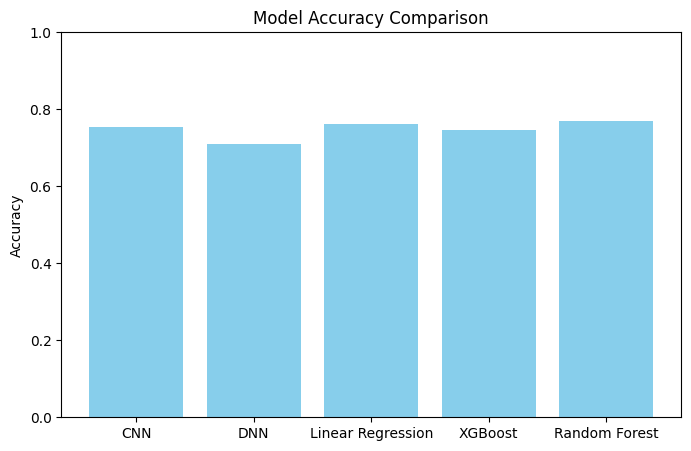

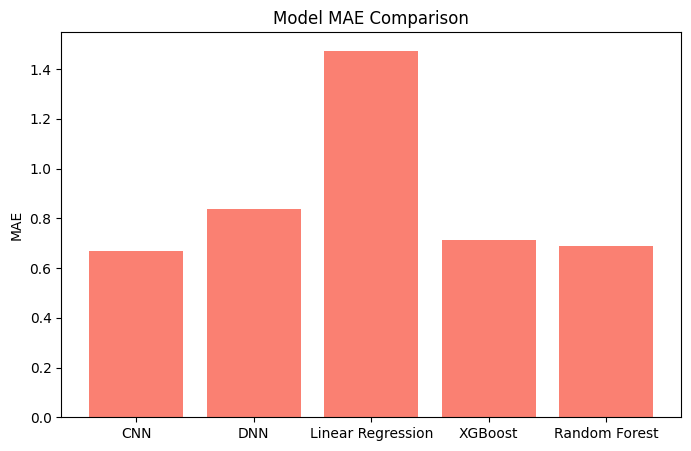

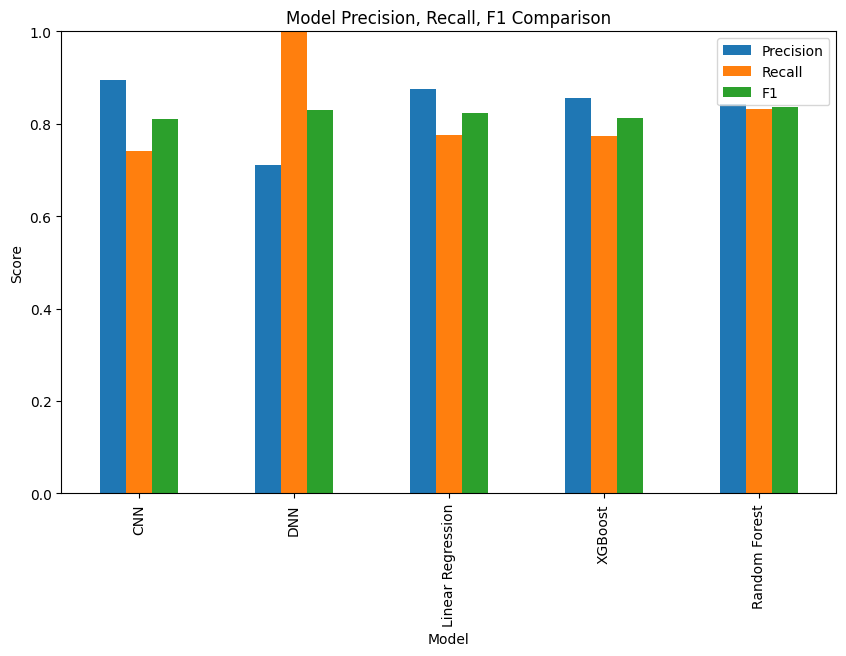

Most efficient model: Random Forest (Accuracy: 0.7703, MAE: 0.6879)


In [109]:
def compare_and_plot(eval_results):
    # Only compare and plot if compare_models is True
    if 'compare_models' in globals() and compare_models:
        # Prepare data for table and plot
        metrics = ["mae", "bin_acc", "precision", "recall", "f1"]
        rows = []
        for model, res in eval_results.items():
            row = [model]
            # Handle MAE key differences
            if "test_mae" in res:
                mae = res["test_mae"]
            elif "test_loss" in res:
                mae = res["test_loss"]
            else:
                mae = None
            row.append(mae)
            # Add the rest of the metrics
            for m in metrics[1:]:
                row.append(res[m])
            rows.append(row)

        results_df = pd.DataFrame(rows, columns=["Model", "MAE", "Accuracy", "Precision", "Recall", "F1"])

        # Display as table
        print("Model Evaluation Results:")
        display(results_df)

        # Plot accuracy comparison
        plt.figure(figsize=(8, 5))
        plt.bar(results_df["Model"], results_df["Accuracy"], color='skyblue')
        plt.ylabel("Accuracy")
        plt.title("Model Accuracy Comparison")
        plt.ylim(0, 1)
        plt.show()

        # Plot MAE comparison
        plt.figure(figsize=(8, 5))
        plt.bar(results_df["Model"], results_df["MAE"], color='salmon')
        plt.ylabel("MAE")
        plt.title("Model MAE Comparison")
        plt.show()

        # Plot Precision, Recall, F1 comparison
        metrics_to_plot = ["Precision", "Recall", "F1"]
        results_df.plot(x="Model", y=metrics_to_plot, kind="bar", figsize=(10, 6))
        plt.title("Model Precision, Recall, F1 Comparison")
        plt.ylim(0, 1)
        plt.ylabel("Score")
        plt.show()

        # Find the most efficient model (highest accuracy, lowest MAE)
        best_model = results_df.sort_values(by=["Accuracy", "MAE"], ascending=[False, True]).iloc[0]
        print(f"Most efficient model: {best_model['Model']} (Accuracy: {best_model['Accuracy']:.4f}, MAE: {best_model['MAE']:.4f})")

compare_and_plot(eval_results)